# Speech speed analysis

Given an audio file *A* of AI generated speech, and the text *T* that was spoken, this notebook we need to analyze the speed of speech, such that we can estimate the following: Given a suffix of *T*, at which time did it start *A*?

Predictors to try:

* Word count

* Character count

* Phoneme count
  * How to count phonemes?

* Syllable count
  * How to count syllables?

* Sentence count

* Token count

* Vowel count???

Requirements:

* Prediction must be fast as it will be repeatedly called when *T* builds up chunk by chunk or sentence by sentence.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os



In [5]:

records = []
# data_dir = "voice_ai_src/temp"
data_dir = "./"
json_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
for f in json_files:
    with open(os.path.join(data_dir, f), 'r') as file:
        data = json.load(file)
        # if data["recording_length"] > 0:
        if data.get("recording_length", 0) > 0:
            records.append(data)

df = pd.DataFrame(records)
df

,audio_file,recording_length,transcription
0,voice_ai_src/temp/ai_20250401-171959-575733.wav,17.45,Certainly! Here is the front of the Audi Q6. M...
1,voice_ai_src/temp/ai_20250401-162427-086008.wav,38.25,Of course! Let's take a look at the Audi A1.\n...
2,voice_ai_src/temp/ai_20250401-163724-206813.wav,44.20,Absolutely! Let's start our tour of the Audi A...
3,voice_ai_src/temp/ai_20250402-104400-763696.wav,16.40,"Absolutely, I'd be happy to! Let's start with ..."
4,voice_ai_src/temp/ai_20250402-100713-147428.wav,16.30,Of course! Let's start with the tour of the Au...
...,...,...,...
71,voice_ai_src/temp/ai_20250402-094808-839772.wav,35.20,Of course! Let's take a tour of the Audi Q3.\n...
72,voice_ai_src/temp/ai_20250402-100038-009329.wav,31.20,"Certainly! Here is the front of the Audi Q6, s..."
73,voice_ai_src/temp/ai_20250402-101003-186733.wav,2.45,Would you like to see the dashboard of the A3?
74,voice_ai_src/temp/ai_20250401-170652-129683.wav,13.20,Of course! Here is the front of the Audi Q6. H...


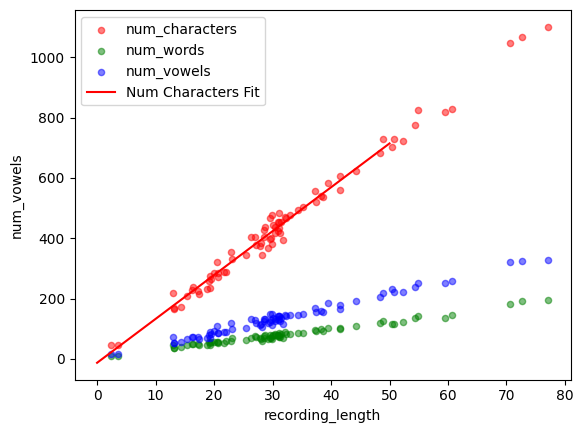

In [6]:
df["num_characters"] = df["transcription"].apply(lambda x: len(x))
df["num_words"] = df["transcription"].apply(lambda x: len(x.split()))
df["num_vowels"] = df["transcription"].apply(lambda x: sum(1 for c in x if c.lower() in 'aeiou'))

metrics = ["num_characters", "num_words", "num_vowels"]
colors = ["red", "green", "blue"]

for metric, color in zip(metrics, colors):
    df.plot.scatter(x="recording_length", y=metric, ax=plt.gca(), c=color, alpha=0.5, label=metric) 


coeff = np.polyfit(df["recording_length"], df["num_characters"], 1)
x = np.linspace(0, 50, 100)
y = np.polyval(coeff, x)
plt.plot(x, y, color='red', label='Num Characters Fit')
plt.legend()
plt.show()

coeff_inv = np.polyfit(df["num_characters"], df["recording_length"], 1)

In [10]:
coeff_inv

array([0.0678655 , 1.27758042])

In [7]:
df[["recording_length"] + metrics].corr()

,recording_length,num_characters,num_words,num_vowels
recording_length,1.000000,0.993370,0.988014,0.989768
num_characters,0.993370,1.000000,0.993219,0.997919
num_words,0.988014,0.993219,1.000000,0.989708
num_vowels,0.989768,0.997919,0.989708,1.000000


In [8]:
rec = df.sort_values(by="recording_length", ascending=False).iloc[0]
text = rec["transcription"]

pattern = "Audi Q3"
prefix = text.split(pattern)[0]
characters = len(prefix)
print(f"Characters before '{pattern}': {characters}")
time_to_pattern = np.polyval(coeff_inv, characters)
print(f"Time to pattern '{pattern}': {time_to_pattern:.2f} seconds")
print(f"File: {rec['audio_file']}")

Characters before 'Audi Q3': 1101
Time to pattern 'Audi Q3': 76.00 seconds
File: voice_ai_src/temp/ai_20250402-163509-467066.wav
